# WGAN

## Import Modules

In [19]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import save_image
from torchvision.utils import make_grid

import numpy as np
import matplotlib.pyplot as plt
import os

In [20]:
# Visualization Tool requires "pip install visdom" (https://github.com/facebookresearch/visdom)
# from visdom_utils import VisFunc
# vf = VisFunc(enval='WGAN')

## MNIST Dataset

In [21]:
batch_size = 100
dataset = datasets.MNIST(root='./dataset', train=True, transform=transforms.ToTensor(), download=True)
dataloader = DataLoader(dataset, batch_size=batch_size)

## Define Model

In [22]:
z_dim = 10

# Generator
G = nn.Sequential(
    nn.Linear(z_dim, 256),
    nn.LeakyReLU(0.2),
    nn.Linear(256, 256),
    nn.LeakyReLU(0.2),
    nn.Linear(256, 784),
    nn.Sigmoid() #instead of Tanh()
    )

# Discriminator
D = nn.Sequential(
    nn.Linear(784, 256),
    nn.LeakyReLU(0.2),
    nn.Linear(256, 256),
    nn.LeakyReLU(0.2),
    nn.Linear(256, 1),
    #nn.Sigmoid()
    )


def weight_init(m): 
    if isinstance(m, nn.Linear):
        size = m.weight.size()
        fan_out = size[0] # number of rows
        fan_in = size[1] # number of columns
        variance = np.sqrt(2.0/(fan_in + fan_out))
        m.weight.data.normal_(0.0, variance)

D.apply(weight_init)
G.apply(weight_init)
G.cuda()
D.cuda()

Sequential(
  (0): Linear(in_features=784, out_features=256, bias=True)
  (1): LeakyReLU(0.2)
  (2): Linear(in_features=256, out_features=256, bias=True)
  (3): LeakyReLU(0.2)
  (4): Linear(in_features=256, out_features=1, bias=True)
)

## Defin Optimizer

In [ ]:
# Optimizers
G_solver = optim.RMSprop(G.parameters(), lr=0.0002)
D_solver = optim.RMSprop(D.parameters(), lr=0.0001)

## Training

Epoch 0 | [300/600] | D_loss: -0.06 | G_loss: 0.08


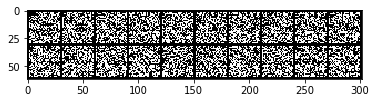

Epoch 0 | [600/600] | D_loss: -1.33 | G_loss: 1.34


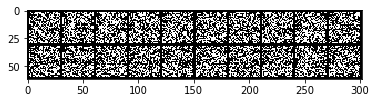

Epoch 1 | [300/600] | D_loss: -5.70 | G_loss: 5.17


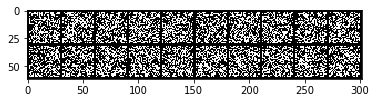

Epoch 1 | [600/600] | D_loss: -7.62 | G_loss: 6.75


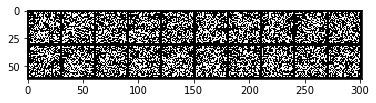

Epoch 2 | [300/600] | D_loss: -7.62 | G_loss: 6.46


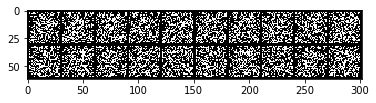

KeyboardInterrupt: 

In [15]:
# for epoch in range(20):
#     for num_iters, batch_data in enumerate(dataloader,0):

for epoch in range(200):
    dataiter = iter(dataloader)
    num_iters = 0
    while num_iters < len(dataloader):
        
        # Train Critic 
        for _ in range(10):
            X, _ = next(dataiter)
            X = Variable(X.view(batch_size, -1).cuda())
            D_real = D(X)
            z = Variable(torch.randn(batch_size, z_dim).cuda())
            X_fake = G(z)
            D_fake = D(X_fake)

            D_loss = -(D_real.mean() - D_fake.mean())
            D_loss.backward()
            D_solver.step()

            # Weight clipping
            for p in D.parameters():
                p.data.clamp_(-0.01, 0.01)

            # Reset gradient
            G.zero_grad()
            D.zero_grad()
            num_iters = num_iters + 1
            
        # Train Generator 
        z = Variable(torch.randn(batch_size, z_dim).cuda())
        X_fake = G(z)
        D_fake = D(X_fake)
        G_loss = -D_fake.mean()

        G_loss.backward()
        G_solver.step()

        # Reset gradient
        G.zero_grad()
        D.zero_grad()
                
        # Print and plot
        if num_iters % 300 == 0:
            print('Epoch {} | [{}/{}] | D_loss: {:.2f} | G_loss: {:.2f}'
                  .format(epoch, num_iters, len(dataloader), float(D_loss.data), float(G_loss.data)))
        
            display_size = 20
            z = Variable(torch.randn(display_size, z_dim)).cuda()
            fake_images = G(z)
            plt.imshow(make_grid((fake_images.data.view(display_size,1,28,28)), nrow=10).cpu().permute(1,2,0).numpy())
            plt.show()  

            if not os.path.exists('wgan_out/'):
                os.makedirs('wgan_out/')
            title = str(epoch)+'_'+str(num_iters)
            save_image(fake_images.data.view(display_size,1,28,28), 'wgan_out/'+title+'.png', nrow=10)
#             vf.imshow_multi(fake_images.data.view(display_size,1,28,28).cpu(), nrow=10, title=title,factor=1)  

## 학습된 Generator 테스트

In [ ]:
z = Variable(torch.randn(batch_size, z_dim)).cuda()
fake_images = G(z)
plt.imshow((fake_images[2].cpu().view(28,28).data).numpy(), cmap='gray')
plt.show()

plt.imshow(make_grid((fake_images.data.view(batch_size,1,28,28))).cpu().permute(1,2,0).numpy())
plt.show()